In [1]:
from IPython import display

import time
import copy
import copy
import json
import zarr
import os
import cv2
import random
    
import tqdm
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torch import nn

from matplotlib import pyplot as plt
import pylab as pl

import urpn_torch

In [2]:
BATCH_SIZE = 2
EPOCHS = 36
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WIEGHT_DECAY = 0.0001
# Flag for feature extracting. When False, we finetune the whole model, when True 
# we only update the reshaped layer params
REGRESSION = False
FEATURE_EXTRACT = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

# Constructor del dataset.
class PulmonsDataset(Dataset):
    def __init__(self, folder_path, data, transform):
        super().__init__()
       
        self.folder_path = folder_path
        self.info = data
        
        self.transform = transform

    def __len__(self): 
        return len(self.info)

    def __getitem__(self, index):
        img_info = self.info[index]
        
        name = list(img_info.keys())[0]
        name_w_ext = name.split(".")[0]

        classification = np.array(img_info[name])
        classification = torch.from_numpy(classification)
        
        dataset = img_info["set"]

        segmentation = zarr.load(os.path.join(self.folder_path, dataset, "solo_mask", f"{name_w_ext}.zarr"))
        img = cv2.imread(os.path.join(self.folder_path, dataset, "image", name), cv2.IMREAD_GRAYSCALE) /255
        
        segmentation = self.transform(segmentation)
        img = self.transform(img)
        
        return img, (segmentation, classification)
    

In [4]:
with open(os.path.join("./in/lung_seg_solo/data.json")) as f:
    data = json.load(f)

datas = {}

for data_img in data:
    img_set = data_img["set"]
    
    if img_set not in datas:
        datas[img_set] = []
        
    datas[img_set].append(data_img)

# dataset = PulmonsDataset("./in/lung_seg_solo/", transform)
# img, (seg, classific) = next(iter(dat))

In [5]:
train = random.choices(datas["train"], k=int(len(datas["train"])*0.4))
validation = random.choices(datas["val"], k=int(len(datas["val"])*0.2))

In [6]:
dataset_train = PulmonsDataset("./in/lung_seg_solo/", train, transform)
data_loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

dataset_val = PulmonsDataset("./in/lung_seg_solo/", validation, transform)
data_loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
def _show_progress(history, phases):
    plt.figure(figsize=(15,10))

    for phase in phases:
        pl.subplot(1, 2, 1)
        pl.title(f'Best Acc: {max(history[phase]["acc"])}')

        pl.plot(history[phase]['acc'], label=phase.capitalize())
        pl.legend()

    for phase in phases:
        pl.subplot(1, 2, 2)
        pl.title(f'Best loss: {min(history[phase]["loss"])}')
        pl.plot(history[phase]['loss'], label=phase.capitalize())

        pl.legend()
    display.clear_output(wait=True) 
    display.display(pl.gcf())
    plt.close() 
    
def train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    num_epochs=25, 
    is_inception=False, 
    do_validation=True, 
    regression=False,
    plot_acc=False,
    device="cpu",
    scheduler=None,
):
    since = time.time()

    history = {}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_std = 0.0
    best_loss = 0.0
    best_loss_std = 0.0
    
    phases = ['train']
    
    if do_validation:
        phases.append('val')
        
    epoch_loss = 0
    epoch_acc = 0
    # try:
    for epoch in range(num_epochs):
        if scheduler is not None:
            scheduler.step()
        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = []
            running_acc = []

            pbar = tqdm.tqdm(dataloaders[phase], desc='Time, he\'s waiting in the wings')
            # Iterate over data.
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                #labels = labels.to(device)

                inputs = inputs.type(torch.float32)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    mask_pred, cls_pred = model(inputs)
                    cls_pred = cls_pred.reshape(-1, 25)

                    mask_gt, class_gt = labels
                    class_gt = class_gt.float()

                    #print(cls_pred.dtype, class_gt.dtype)
                    loss = criterion(mask_pred.to(device), cls_pred.to(device), mask_gt.to(device), class_gt.to(device))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss.append(loss.item())

                pbar.set_description('Epoch {}/{} - {} - LOSS: {:.4f}'.format(epoch, num_epochs - 1, phase.capitalize(), np.mean(running_loss)))

            epoch_loss = np.mean(running_loss)

            # deep copy the model
            if (phase == 'val' or not 'val' in phases) and epoch_loss > best_loss:
                best_loss = epoch_loss

                best_loss_std = np.std(running_loss)
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase not in history:
                history[phase] = {"acc": [], "loss": []}

            history[phase]["acc"].append(epoch_acc)
            history[phase]["loss"].append(epoch_loss)
        if plot_acc:
            _show_progress(history, phases)
#     except KeyboardInterrupt:
#         print('Interrupted')
#     except Exception as e:
#         print(e)
#         traceback.print_exc()
#     finally:
#         time_elapsed = time.time() - since
#         print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         print('Best val Acc: [{:4f}-{:4f}]'.format(best_acc - best_acc_std/2, best_acc + best_acc_std/2))
        
#         # load best model weights
#         # model.load_state_dict(best_model_wts)
#         return model, history

In [8]:
from urpn_torch.usolo import model, loss

net = model.URPN(in_channels=1, features=8, mask_size=(256,256))
net = net.to(DEVICE)
net = nn.DataParallel(net)


In [9]:
from torchsummary import summary

summary(net, input_size=(1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              72
       BatchNorm2d-2          [-1, 8, 512, 512]              16
              ReLU-3          [-1, 8, 512, 512]               0
            Conv2d-4          [-1, 8, 512, 512]             576
            Conv2d-5          [-1, 8, 512, 512]              72
       BatchNorm2d-6          [-1, 8, 512, 512]              16
              ReLU-7          [-1, 8, 512, 512]               0
       BatchNorm2d-8          [-1, 8, 512, 512]              16
              ReLU-9          [-1, 8, 512, 512]               0
        MaxPool2d-10          [-1, 8, 256, 256]               0
           Conv2d-11          [-1, 8, 512, 512]             576
           Conv2d-12         [-1, 16, 256, 256]           1,152
      BatchNorm2d-13          [-1, 8, 512, 512]              16
      BatchNorm2d-14         [-1, 16, 2

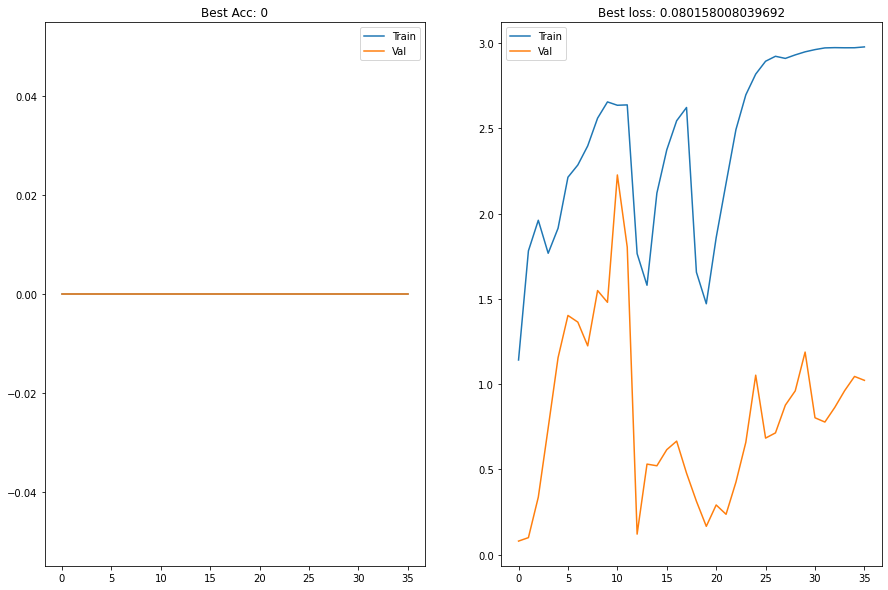

TypeError: cannot unpack non-iterable NoneType object

In [10]:
criterion = loss.SoloLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, weight_decay=WIEGHT_DECAY, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# Train and evaluate
net, hist = train_model(
    net, 
    {"train": data_loader_train, "val": data_loader_val}, 
    criterion, 
    optimizer, 
    num_epochs=EPOCHS, 
    do_validation=True,
    regression=False,
    plot_acc=True,
    device = DEVICE,
    scheduler=scheduler
)

In [11]:
img, (seg_gt, cls_gt) = next(iter(data_loader_val))

In [12]:
seg, classif = net(img.to(DEVICE).float())

In [13]:
print(seg.shape, classif.shape)

torch.Size([2, 125, 256, 256]) torch.Size([2, 5, 5, 5])


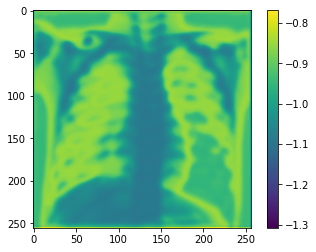

In [14]:
plt.imshow(seg[0][117].cpu().detach())
plt.colorbar()

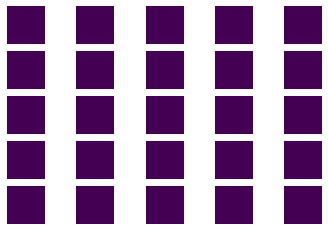

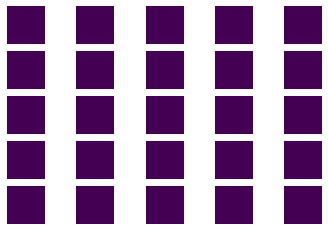

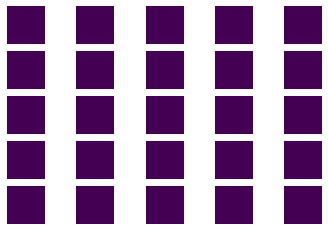

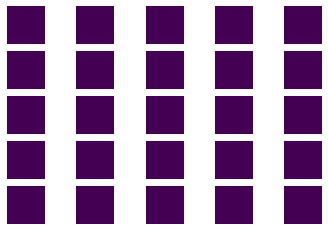

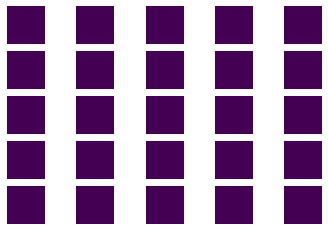

In [15]:
from matplotlib import pyplot as plt

for j in range(5):
    classific= classif[0][j].flatten()
    plt.figure()
    for i in range(j*25, (j+1) * 25):
        plt.subplot(5,5, (i - (j*25)) + 1)
        plt.axis('off')
        aux = seg[0][i].detach().cpu().numpy()
        aux[aux < 0.5] = 0

        if classific[i - (j * 25)] < 0.1:
            aux = np.zeros_like(aux)
        else:
            print(f"{i}_{j} {classific[i - (j * 25)]}")

        plt.imshow(aux)

In [16]:
classif[0][0].flatten()

tensor([-2.6514, -2.5777, -2.2858, -3.0682, -2.5252, -2.5140, -1.3028, -0.1859,
        -2.0717, -2.4985, -3.0789, -2.1596, -1.8065, -2.4678, -2.6000, -2.3822,
        -1.0750, -0.3277, -1.9972, -2.7544, -2.9280, -2.2078, -1.9565, -2.2313,
        -2.7091], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)